# King County Home Prediction

By: Zachary Greenberg

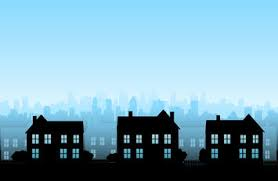

# Overview

The housing market in King County, Washington is highly diverse. I am seeking to create a predictive model to accurately forecast the prices in the market. Using the detailed factors of a home, including number of bathrooms, zipcode, renovation status, and so on I will analyze the data to be used in a Multiple Linear Regression model. My goal is to come within $200000 for my model estimates. I will use RMSE as an indicator of my model performance. 

# Business Problem
When it comes to buying a house, there are many factors that affect the prices you will pay. If we can create a model to effectively predict the price of homes based on these factors, this will increase our understanding of the housing market and allow us to be more certain in our future pricing estimates and appraisals. 

# Data Understanding

The data for this model comes from a [2015 Kings County Housing Dataset](https://www.kaggle.com/harlfoxem/housesalesprediction) that is from Kaggle. The following information has been provided:

* **price** - Price is prediction TARGET  


* **id** - unique ID for a house
* **date** - Date day house was sold
* **bedrooms** - Number of bedrooms
* **bathrooms** - Number of bathrooms
* **sqft_living** - square footage of the home
* **sqft_lot** - square footage of the lot
* **floors** - Total floors (levels) in house
* **waterfront** - Whether house has a view to a waterfront
* **view** - Number of times house has been viewed
* **condition** - How good the condition is (overall)
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house (apart from basement)
* **sqft_basement** - square footage of the basement
* **yr_built** - Year when house was built
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip code in which house is located
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import pickle
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading in the training data
df = pd.read_csv('Data/kc_house_data_train.csv', index_col = 'Unnamed: 0')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,...,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,...,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,...,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,...,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,...,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [4]:
df.dtypes.head(2)

id       int64
date    object
dtype: object

Quick housekeeping, I am going to change the date to a datetime column:

In [5]:
df['date'] = pd.to_datetime(df['date'])

Aside from changing the datetime, another immediate observation I had was that floors and bathrooms are floats, meaning half floors and half baths can be included in this data set.

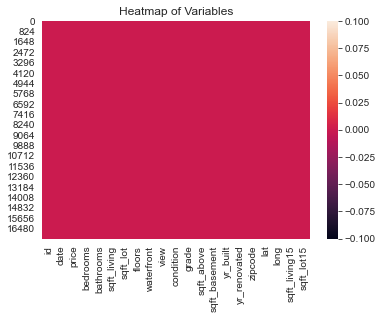

In [6]:
#Checking for missing values
sns.heatmap(df.isna())
plt.title('Heatmap of Variables');

There are no missing values in this dataset.

In [7]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.729000e+04,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,4.565502e+09,5.407395e+05,3.372470,2.111943,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1789.306015,292.158589,1970.792019,83.806304,98078.193175,47.560058,-122.214258,1987.986698,12873.475824
std,2.874656e+09,3.733190e+05,0.939346,0.770476,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,829.265107,443.151874,29.343516,400.329376,53.607949,0.138412,0.140857,684.802635,27227.437583
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000
25%,2.114701e+09,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000
50%,3.903650e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000
75%,7.301150e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000


Observations: There are some fishy data entries going on with homes that have 0 bedrooms. The max bedrooms is 33? Also the homes that have 0 bathrooms do not seem logical.

Before I clean the data, I am interested in taking a look at which features are strongly correlated with price. This will help determine which to further investigate and/or clean.

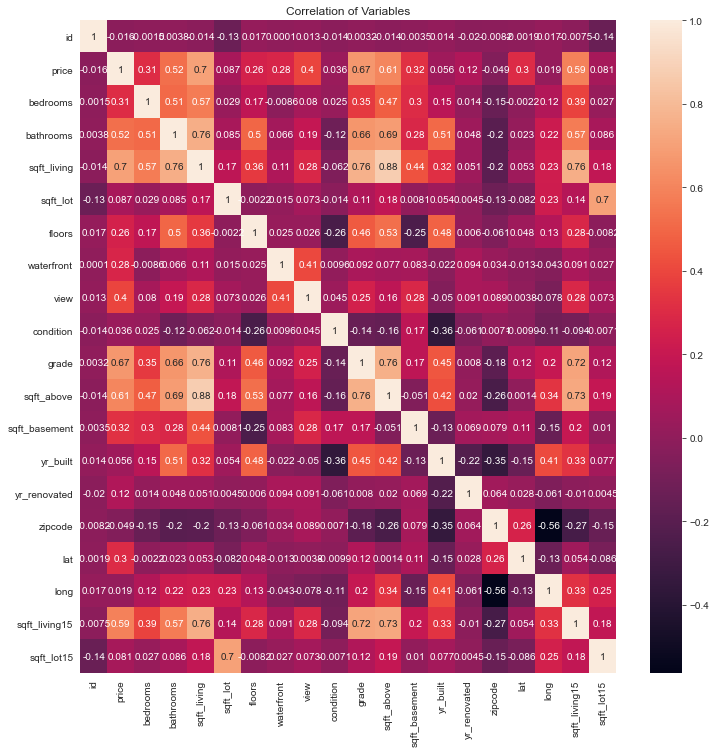

In [8]:
fig, ax = plt.subplots(figsize=(12,12))
ax=sns.heatmap(df.corr(), annot=True)
ax.set_title('Correlation of Variables');

With my self-decided threshold of .9, I do not see any threats of multicollinearity. I am interested in investigating bedrooms, bathrooms, sqft_living, view, grade, sqft_above, sqft_basement, and sqft_living 15. All seem to be decently correlated with price. 

# Cleaning / Data Analysis

*Bedrooms*

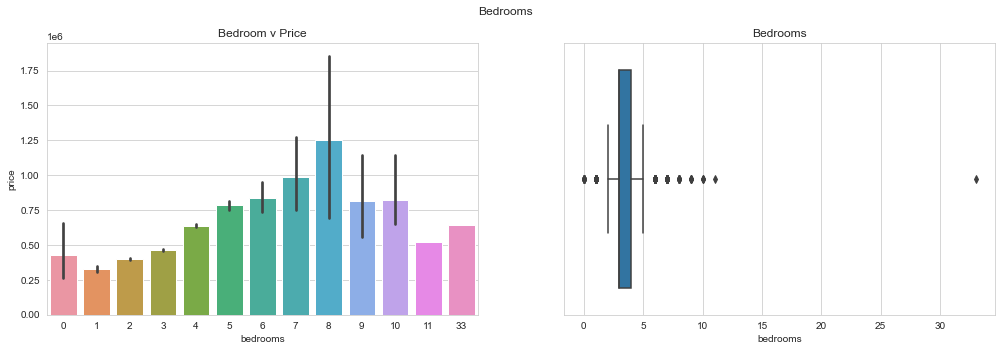

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))
fig.suptitle('Bedrooms')

sns.barplot(ax=axes[0], x=df.bedrooms, y=df.price)
axes[0].set_title('Bedroom v Price')

sns.boxplot(ax=axes[1], x=df.bedrooms)
axes[1].set_title('Bedrooms');

It is interesting to note that value of a home does not seem to increase past 8 bedrooms. I am going to make all bedrooms above that as 8. The 33 bedrooms entry seems like a typo, so I am going to change that entry to the mean. I will also change the 0 bedrooms as well. It doesn't seem likely for a home to have 0 bedrooms. I am going to assign them to the mean as well.

In [10]:
conditions = [df['bedrooms'] == 33, df['bedrooms'] > 8, df['bedrooms'] < 1]
choices = [df['bedrooms'].mean(), 8, df['bedrooms'].mean()]
df['bedrooms'] = np.select(conditions, choices, df['bedrooms'])

In [11]:
#Saving this variable for export
bedroom_mean = df.bedrooms.mean()

*Bathrooms*

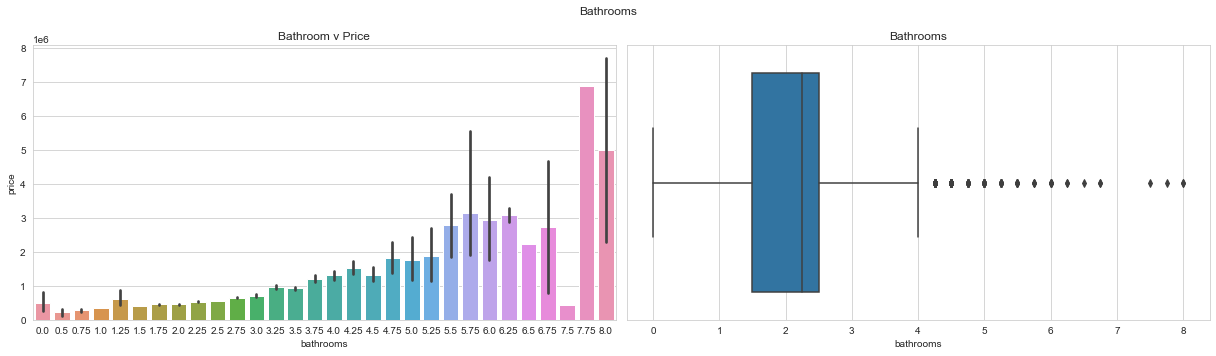

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))
fig.suptitle('Bathrooms')

sns.barplot(ax=axes[0], x=df['bathrooms'], y=df['price'])
axes[0].set_title('Bathroom v Price')

sns.boxplot(ax=axes[1], x=df['bathrooms'])
axes[1].set_title('Bathrooms')
plt.tight_layout()

The distribution is less linear than I hoped. First of all I am going to round them to single digits. I don't think a .5 or .25 bathroom will make that large of a difference in price. It doesn't look it according the the data.

In [13]:
df.bathrooms = round(df.bathrooms, 0)

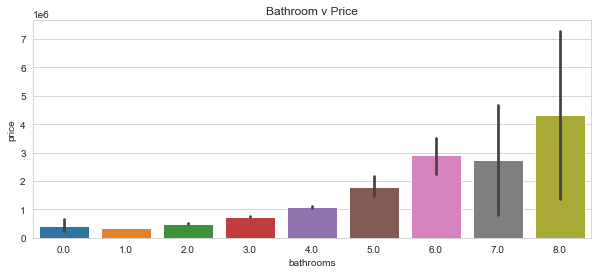

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(x=df['bathrooms'], y=df['price'])
ax.set_title('Bathroom v Price');

That looks a lot more linear and easier to work with.

In [15]:
#looking at the difference in sqft for bathrooms
df[df['bathrooms'] == 1]['sqft_living'].mean(), df[df['bathrooms'] == 0]['sqft_living'].mean()

(1181.745408486384, 1698.5454545454545)

I wouldn't think a home with 0 bathrooms has more squarefoot than a home with 1 bathroom. I also don't believe that a home would have 0 bathrooms, so I will make an adjustment. I will impute these values with the median because of the slight skew. 

In [16]:
df.bathrooms=np.where(df['bathrooms']==0, df['bathrooms'].median(), df['bathrooms'])

In [17]:
#Saving this amount for exporting
bathroom_median = df.bathrooms.median()

*Sqft_Living*

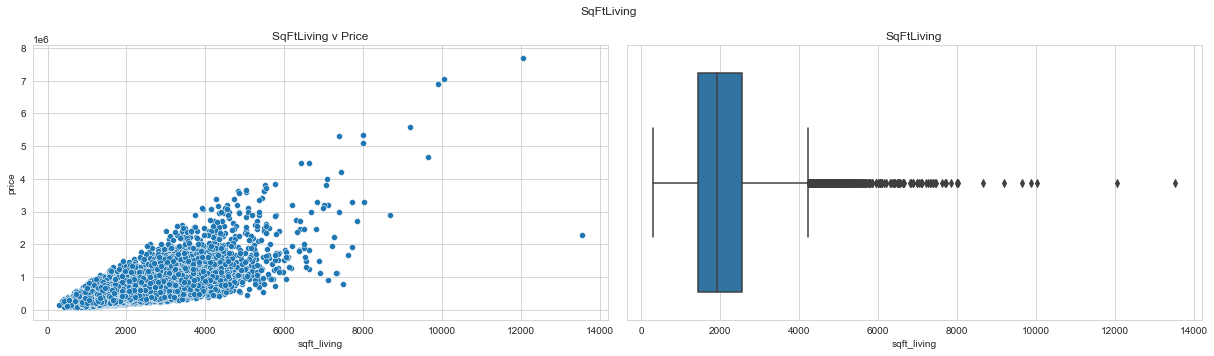

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))
fig.suptitle('SqFtLiving')

sns.scatterplot(ax=axes[0], x=df.sqft_living, y=df.price)
axes[0].set_title('SqFtLiving v Price')

sns.boxplot(ax=axes[1], x=df.sqft_living)
axes[1].set_title('SqFtLiving')
plt.tight_layout()

This feature looks positively correlated with price. I don't think I would be too concerned about these outliers. There is one point at the bottom right does seem a bit troubling though. I am going to change that to the median, as I believe it may be a typo. It is the datapoint with the largest sqft and it is not adhereing to the general positive correlation present.

In [19]:
df.sqft_living = np.where(df['sqft_living'] == 13540, df['sqft_living'].median(), df['sqft_living'])

In [20]:
#saving the median for export:
sqft_living_median = df['sqft_living'].median()

*View*

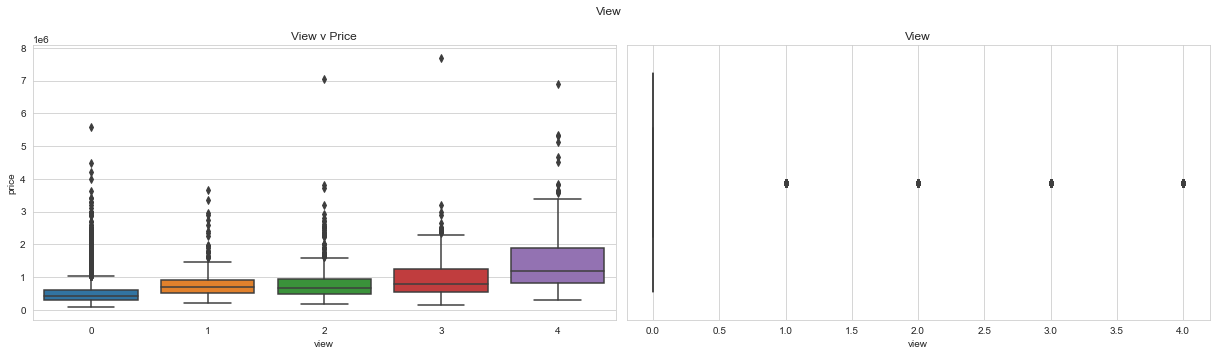

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))
fig.suptitle('View')

sns.boxplot(ax=axes[0], x=df.view, y=df.price)
axes[0].set_title('View v Price')

sns.boxplot(ax=axes[1], x=df.view)
axes[1].set_title('View')
plt.tight_layout()

The correlation does look gradually linear, albeit the outliers, and it does have a moderate correlation with price according to the heatmap. So it will stay for now.

*Grade*

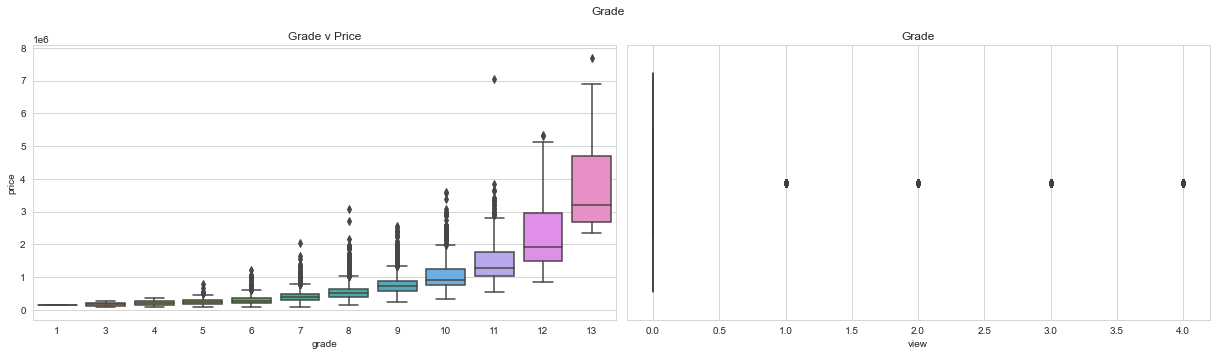

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))
fig.suptitle('Grade')

sns.boxplot(ax=axes[0], x=df.grade, y=df.price)
axes[0].set_title('Grade v Price')

sns.boxplot(ax=axes[1], x=df.view)
axes[1].set_title('Grade')
plt.tight_layout()

This looks almost exponential. There must be some importance here. I will most likely make this into a dummy variable.

*Sqft_Above*

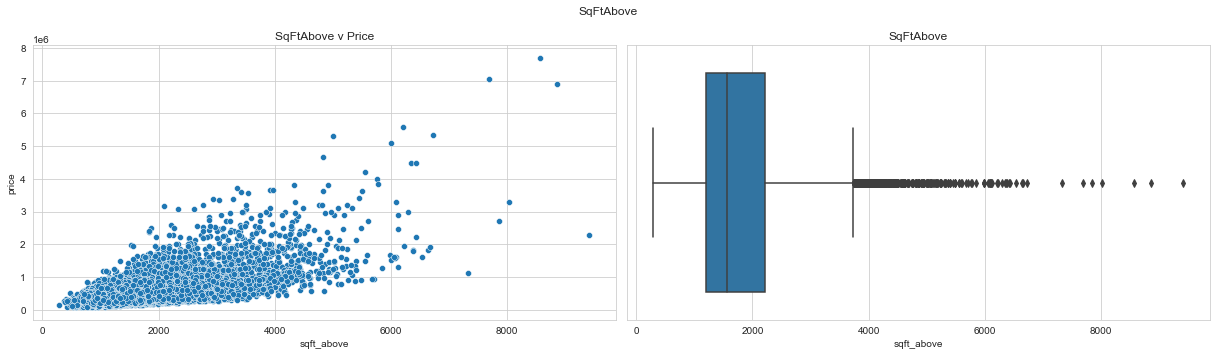

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))
fig.suptitle('SqFtAbove')

sns.scatterplot(ax=axes[0], x=df.sqft_above, y=df.price)
axes[0].set_title('SqFtAbove v Price')

sns.boxplot(ax=axes[1], x=df.sqft_above)
axes[1].set_title('SqFtAbove')
plt.tight_layout()

The distribution looks positively linear. I am going to adjust the furthest point as it also seems like a typo. I will impute it with the median.

In [24]:
df.sqft_above = np.where(df['sqft_above'] == 9410, df['sqft_above'].median(), df['sqft_above'])

In [25]:
#saving the median for export:
sqft_above_median = df['sqft_above'].median()

*Sqft_Basement*

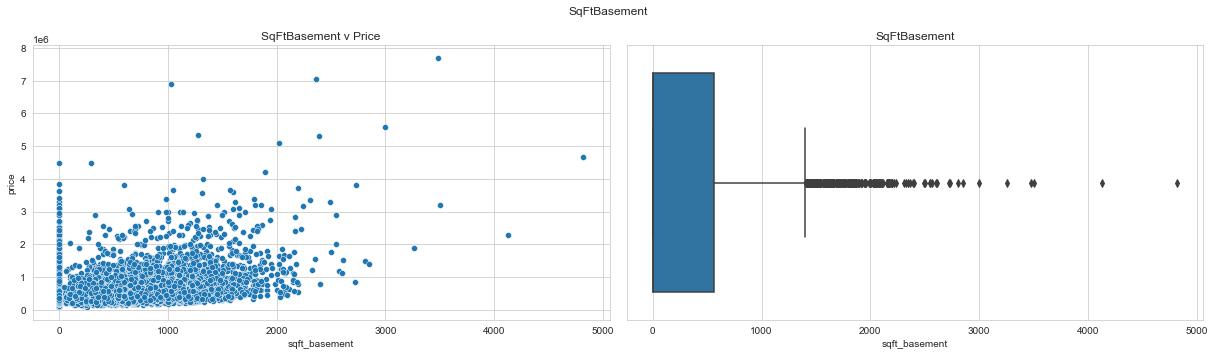

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))
fig.suptitle('SqFtBasement')

sns.scatterplot(ax=axes[0], x=df.sqft_basement, y=df.price)
axes[0].set_title('SqFtBasement v Price')

sns.boxplot(ax=axes[1], x=df.sqft_basement)
axes[1].set_title('SqFtBasement')
plt.tight_layout()

Again, this does look linear for the most part. I am assuming here that 0 means there is no basement.

*Sqft_Living15*

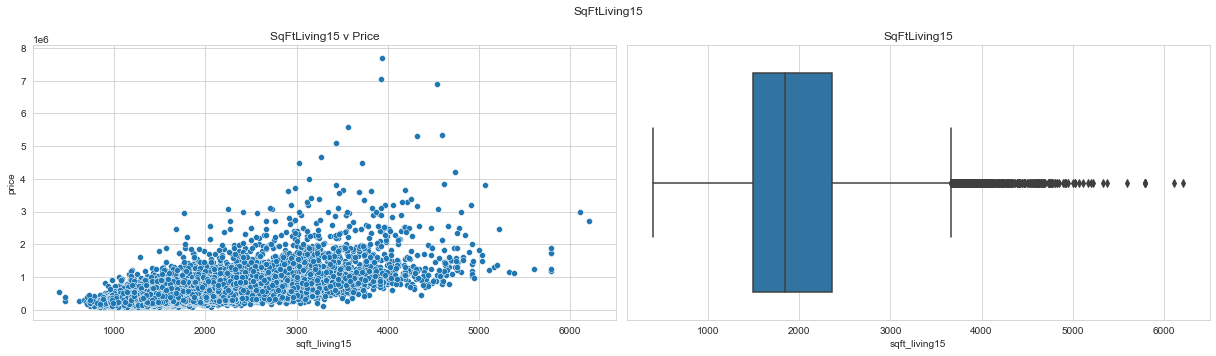

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))
fig.suptitle('SqFtLiving15')

sns.scatterplot(ax=axes[0], x=df.sqft_living15, y=df.price)
axes[0].set_title('SqFtLiving15 v Price')

sns.boxplot(ax=axes[1], x=df.sqft_living15)
axes[1].set_title('SqFtLiving15')
plt.tight_layout()

This also looks positive and linear. I think I will serve the model well.

# New Features

Starting with date, because I haven't been able to see anything on the heatmap, I would like to isolate the month to see if it has an affect on price:

In [28]:
df['month'] = df['date'].dt.month

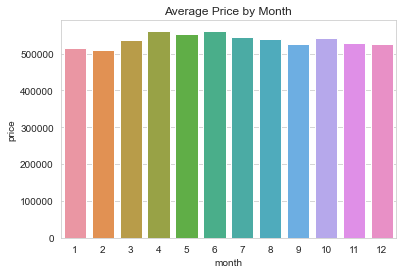

In [29]:
month = df.groupby('month')['price'].mean()

fig, ax = plt.subplots()
ax=sns.barplot(x=month.index, y=month.values, data = df)
ax.set_title('Average Price by Month')
ax.set_ylabel('price')
plt.savefig('Visualizations/month.png')

To truly see if the renovation of a home was worth it, I am going to create a been_renovated column.

In [30]:
df['been_renovated']=np.where(df['yr_renovated'] == 0, 0, 1)

In [31]:
df['been_renovated'].value_counts()

0    16564
1      726
Name: been_renovated, dtype: int64

Only about 5% have been renovated. I am interested to see if that makes a difference.

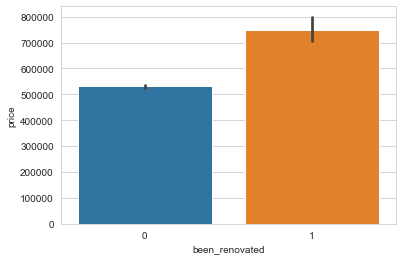

In [32]:
fig, ax = plt.subplots()
ax=sns.barplot(x='been_renovated', y='price', data = df)

According to this graph it seems there is a difference in price in homes that are renovated vs homes that are not renovated. 

I am going to create a yard size column by subtracting the sqft_lot from (sqft_living/floors) 

In [33]:
df['yard_size'] = df['sqft_lot'] - (df['sqft_living']/df['floors'])

In [34]:
#I am replacing the negative values with the mean. It is not logical to have negative yard space.
df['yard_size']=np.where(df['yard_size'] < 0, df['yard_size'].mean(), df['yard_size'])

In [35]:
#saving the mean for export:
yard_size_mean = df['yard_size'].mean()

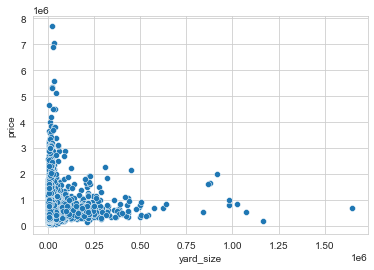

In [36]:
fig, ax = plt.subplots()
ax=sns.scatterplot(x='yard_size', y='price', data = df)

In [37]:
#to get a more linear approach, I will log this variable
df['log_yard'] = np.log(df['yard_size'])

I am going to create a polynomial feature of sqft_living15 and sqft_lot15 to see if that can make an impact. It is essentially combining the effect of those two columns together.

In [38]:
df['neighbor'] = df['sqft_living15']*df['sqft_lot15']

In [39]:
#I also decided to log this feature for linearity sake.
df['log_neighbor'] = np.log(df['neighbor'])

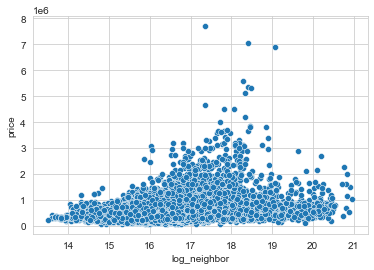

In [40]:
fig, ax = plt.subplots()
ax=sns.scatterplot(x='log_neighbor', y='price', data = df)


In [41]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month', 'been_renovated',
       'yard_size', 'log_yard', 'neighbor', 'log_neighbor'],
      dtype='object')

Finally with the been_renovated column I have above, I will create an interaction feature of that with bathrooms because everyone enjoys a nicely renovated bathroom. 

In [42]:
df['reno_bath'] = df['been_renovated']*df['bathrooms']

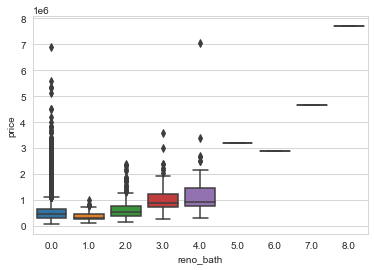

In [43]:
fig, ax = plt.subplots()
ax=sns.boxplot(x='reno_bath', y='price', data = df)

I would have worried about this relationship being seemingly exponential, but I plan on turning these into dummy variables below.

# Statistical Testing

I did not look at the floors or waterfront columns above. That was on purpose because I am interested in performing hypothesis testing on them to see how useful they can be.

*Floors*

>NULL Hypothesis: The mean prices of homes with specific floors are equal.  
ALT Hypothesis: The mean prices of homes with specific floors are not equal.

In [44]:
#putting the floors in to groups
one = df[df['floors'] == 1]['price']
one_five = df[df['floors'] == 1.5]['price']
two = df[df['floors'] == 2]['price']
two_five= df[df['floors'] == 2.5]['price']
three = df[df['floors'] == 3]['price']
three_five = df[df['floors'] == 3.5]['price']


print(stats.f_oneway(one, one_five, two, two_five, three, three_five))

F_onewayResult(statistic=323.01056083264746, pvalue=0.0)


>I reject the null hypothesis. There is statistical significance to suggest the mean prices of homes with specific floors are not equal. There must be something to owning a house with a specific number of floors then.

*Waterfront*

>NULL Hypothesis: The mean prices of waterfront and non waterfront properties are equal.  
ALT Hypothesis: The mean prices of waterfront and non waterfront properties are not equal.

In [45]:
water = df[df['waterfront'] == 1]['price']
no = df[df['waterfront'] == 0]['price']

print(stats.f_oneway(water, no))

F_onewayResult(statistic=1423.0476869705938, pvalue=2.4650383176307687e-299)


>I reject the null hypothesis. There is statistical significance to suggest the means are not equal. Waterfront properties are most likely very different in price than nonwaterfront homes.

While I am at it, I will also do a test on the Month category I created.

>NULL Hypothesis: The mean prices of homes sold in each month are equal.  
ALT Hypothesis: The mean prices of homes sold in each month are not equal.

In [48]:
one = df[df['month'] == 1]['price']
two = df[df['month'] == 2]['price']
three = df[df['month'] == 3]['price']
four = df[df['month'] == 4]['price']
five = df[df['month'] == 5]['price']
six = df[df['month'] == 6]['price']
seven = df[df['month'] == 7]['price']
eight = df[df['month'] == 8]['price']
nine = df[df['month'] == 9]['price']
ten = df[df['month'] == 10]['price']
eleven = df[df['month'] == 11]['price']
twelve = df[df['month'] == 12]['price']

print(stats.f_oneway(one, two, three, four, five, six, seven, eight, nine, ten , eleven, twelve))

F_onewayResult(statistic=2.7046975005044085, pvalue=0.0017444151469153434)


>I reject the null hypothesis. There is statistical significance to suggest the means are not equal. The mean prices of homes sold in each month are most likely important in price prediction.

# Final Preparation for Initial Model

Before I go ahead with my first model I am going to make a final check for multicollinearity. Once that it done, I will get the dummy variables for my categorical variables of interest. 

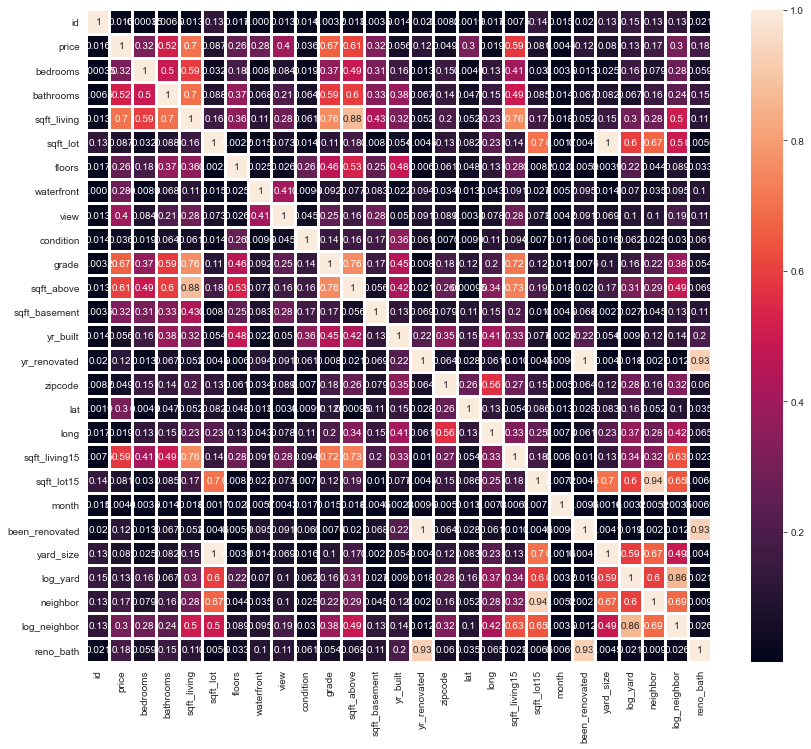

In [49]:
fig, ax = plt.subplots(figsize=(14,12))
ax=sns.heatmap(abs(df.corr()), linewidth = 2, annot=True)

There are a couple variables that do violate the multicollinearity assumption. I will drop them and any unused columns below. 

In [50]:
#creating a dataframe for the inital model, dropping unused columns and multicollinear ones
model_data = df.copy()

#unused columns:
model_data.drop(columns=['id', 'date', 'lat', 'long', 'yr_built', 'sqft_lot', 'condition'], inplace = True)

#issues with multicollinearity:
#the threshold is at .9
model_data.drop(columns=['yr_renovated', 'been_renovated', 'sqft_lot15', 'yard_size', 'neighbor'], inplace = True)


I am getting dummies for my categorical variables in the cell below. As a last minute decision, I decided to put zipcode in. Logically speaking, I feel that location would highly affect the price, despite the low correlation on the heatmap. 

In [51]:
#creating dummies for the categorical values
model_data = pd.get_dummies(model_data, columns = ['view','grade', 'month', 'zipcode'], drop_first = True)

# Running First Model

For my first model, I am going to incorporate all the columns I looked at above and see what comes of it. 

In [52]:
model_data.columns[:5]

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors'], dtype='object')

In [53]:
#getting a list of columns excluding price
features = list(model_data.columns[1:])

In [54]:
outcome = 'price'
x_cols = features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=model_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     823.4
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        12:20:24   Log-Likelihood:            -2.3076e+05
No. Observations:               17290   AIC:                         4.617e+05
Df Residuals:                   17183   BIC:                         4.626e+05
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.436e+04   1.58e+05     -0.217      0.828   -3.45e+05    2.76e+05
bedrooms       -1.22e+04   1716.023     -7.112      0.000   -1.56e+04   -8841.254
bathrooms       1.55e+04   2305.989      6.723      0.000     1.1e+04       2e+04
sqft_living     -22.4571     41.033     -0.547      0.584    -102.886      57.972
floors        -2.674e+04   3254.321     -8.218      0.000   -3.31e+04   -2.04e+04
waterfront     5.673e+05   1.65e+04     34.353      0.000    5.35e+05       6e+05
sqft_above      191.1897     41.461      4.611      0.000     109.921     272.458
sqft_basement   149.9504     41.119      3.647      0.000      69.354     230.547
sqft_living15    23.2543      3.706      6.275      0.000      15.991      30.518
log_yard       2.915e+04   2761.221     10.558      0.000    2.37e+04    3.46e+04
log_neighbor  -1.765e+04   3570.134     -4.944      0.000   -2.47e+04   -1.07e+04
reno_bath      2.837e+04   2420.679     11.719      0.000    2.36e+04    3.31e+04
view_1         7.843e+04   9675.822      8.105      0.000    5.95e+04    9.74e+04
view_2         7.104e+04   5863.699     12.115      0.000    5.95e+04    8.25e+04
view_3         1.383e+05   8051.603     17.182      0.000    1.23e+05    1.54e+05
view_4         2.988e+05   1.21e+04     24.743      0.000    2.75e+05    3.23e+05
grade_3        9.066e+04   1.87e+05      0.484      0.629   -2.77e+05    4.58e+05
grade_4        4.654e+04   1.57e+05      0.297      0.766    -2.6e+05    3.54e+05
grade_5        1.256e+04   1.54e+05      0.082      0.935   -2.88e+05    3.14e+05
grade_6          1.1e+04   1.53e+05      0.072      0.943   -2.89e+05    3.11e+05
grade_7        1.102e+04   1.53e+05      0.072      0.943   -2.89e+05    3.11e+05
grade_8        3.305e+04   1.53e+05      0.216      0.829   -2.67e+05    3.33e+05
grade_9        9.644e+04   1.53e+05      0.629      0.529   -2.04e+05    3.97e+05
grade_10       2.137e+05   1.53e+05      1.393      0.164   -8.71e+04    5.15e+05
grade_11       4.036e+05   1.54e+05      2.625      0.009    1.02e+05    7.05e+05
grade_12       8.579e+05   1.55e+05      5.542      0.000    5.54e+05    1.16e+06
grade_13       2.052e+06   1.61e+05     12.744      0.000    1.74e+06    2.37e+06
month_2        3897.7551   7262.580      0.537      0.591   -1.03e+04    1.81e+04
month_3         2.41e+04   6693.174      3.600      0.000     1.1e+04    3.72e+04
month_4        3.505e+04   6493.173      5.398      0.000    2.23e+04    4.78e+04
month_5        4928.8186   6433.777      0.766      0.444   -7682.040    1.75e+04
month_6        5967.6443   6525.500      0.915      0.360   -6823.002    1.88e+04
month_7       -1438.8539   6520.918     -0.221      0.825   -1.42e+04    1.13e+04
month_8          55.2969   6647.935      0.008      0.993    -1.3e+04    1.31e+04
month_9       -1.082e+04   6782.089     -1.595   

The first run of the model has an r-squared .84. That is a great score. When looking at the coefficients, it looks as though Grade 13 had the highest magnitude of all of them. I did some research into the grades and found out it is a Washington specific grade on the quality of the home structures. Waterfront, bathrooms, and views are among other positive affects on price. Also I was right at the last second to include zipcode. That was a good choice. 

**Checking The RMSE & Assumptions**

In [55]:
#creating an instance of LinearRegression
lr = LinearRegression()

#fitting the model
lr.fit(model_data[features], model_data['price'])

LinearRegression()

In [56]:
#getting predictions
y_pred = lr.predict(model_data[features])

In [57]:
#getting error values
mae = metrics.mean_absolute_error(model_data['price'], y_pred)
mse = metrics.mean_squared_error(model_data['price'], y_pred)
rmse = np.sqrt(mse)

print(mae)
print(rmse)

89031.0517966034
151404.9223578736


The rmse is not to terrible at the 151404 mark. I am now going to check the assumptions to see if they can tell me what kind of adjustments may need to be made.

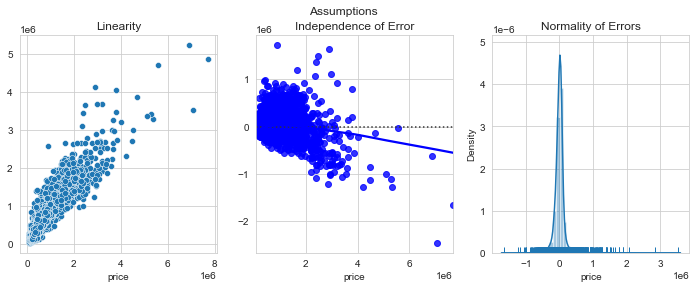

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
fig.suptitle('Assumptions')
sns.scatterplot(x=model_data['price'], y=y_pred, ax=ax[0])
ax[0].set_title('Linearity')
sns.residplot(x=model_data['price'], y=y_pred, lowess=True, color="b", ax=ax[1])
ax[1].set_title('Independence of Error')
residuals =  model_data['price']- y_pred
sns.distplot(residuals, kde=True, rug=True)
ax[2].set_title('Normality of Errors');

Comments: The residuals are not homoscedastic nor do the errors seem to be normally distributed.

# Non-Linear Transformations

The r2 value is pretty decent, but the linear model assumptions have been violated. I will try to correct for this with some polynomial features.

In [59]:
#making a copy of the DataFrame
model_data2 = model_data.copy()

#bed*bath
model_data2['bedbath'] = model_data2['bedrooms']*model_data2['bathrooms']
#sqft_living**2
model_data2['sqft_living2'] = model_data2['sqft_living'] * model_data2['sqft_living']
#sqft_living15**2
model_data2['sqft_living152'] = model_data2['sqft_living15'] * model_data2['sqft_living15']
#floor**2
model_data2['floors2'] = df['floors']*df['floors']

#dropping some columns to avoid multicollinearity:
model_data2.drop(columns=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_living15', 'floors'], inplace = True)

In [60]:
#getting the columns except for price
features2 = list(model_data2.columns[1:])

outcome = 'price'
x_cols = features2
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=model_data2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     892.3
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        12:20:28   Log-Likelihood:            -2.3025e+05
No. Observations:               17290   AIC:                         4.607e+05
Df Residuals:                   17184   BIC:                         4.615e+05
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.816e+05   1.54e+05     -1.183      0.237   -4.83e+05    1.19e+05
waterfront      5.497e+05    1.6e+04     34.299      0.000    5.18e+05    5.81e+05
sqft_above         9.8303      5.483      1.793      0.073      -0.917      20.577
sqft_basement    -21.4084      5.571     -3.843      0.000     -32.328     -10.489
log_yard        2.179e+04   2622.162      8.311      0.000    1.67e+04    2.69e+04
log_neighbor   -2816.0975   3315.323     -0.849      0.396   -9314.468    3682.273
reno_bath       2.685e+04   2341.675     11.468      0.000    2.23e+04    3.14e+04
view_1          8.374e+04   9380.205      8.927      0.000    6.54e+04    1.02e+05
view_2          7.345e+04   5678.691     12.934      0.000    6.23e+04    8.46e+04
view_3          1.356e+05   7810.485     17.355      0.000     1.2e+05    1.51e+05
view_4          2.987e+05   1.17e+04     25.537      0.000    2.76e+05    3.22e+05
grade_3         1.515e+05   1.82e+05      0.832      0.405   -2.05e+05    5.08e+05
grade_4         1.038e+05   1.52e+05      0.683      0.495   -1.94e+05    4.02e+05
grade_5         9.547e+04   1.49e+05      0.640      0.522   -1.97e+05    3.88e+05
grade_6         1.148e+05   1.49e+05      0.772      0.440   -1.77e+05    4.06e+05
grade_7         1.455e+05   1.49e+05      0.978      0.328   -1.46e+05    4.37e+05
grade_8         1.872e+05   1.49e+05      1.258      0.208   -1.04e+05    4.79e+05
grade_9         2.544e+05   1.49e+05      1.709      0.087   -3.74e+04    5.46e+05
grade_10        3.556e+05   1.49e+05      2.387      0.017    6.36e+04    6.48e+05
grade_11          4.8e+05   1.49e+05      3.216      0.001    1.87e+05    7.72e+05
grade_12         8.04e+05    1.5e+05      5.353      0.000     5.1e+05     1.1e+06
grade_13        1.486e+06   1.57e+05      9.452      0.000    1.18e+06    1.79e+06
month_2         4510.2662   7049.662      0.640      0.522   -9307.791    1.83e+04
month_3         2.536e+04   6496.450      3.904      0.000    1.26e+04    3.81e+04
month_4         3.621e+04   6302.550      5.745      0.000    2.39e+04    4.86e+04
month_5         5191.1072   6244.240      0.831      0.406   -7048.240    1.74e+04
month_6         5752.6402   6333.798      0.908      0.364   -6662.250    1.82e+04
month_7        -1165.7809   6329.485     -0.184      0.854   -1.36e+04    1.12e+04
month_8         1716.8299   6453.039      0.266      0.790   -1.09e+04    1.44e+04
month_9        -8494.7100   6583.605     -1.290      0.197   -2.14e+04    4409.827
month_10       -3668.0661   6497.336     -0.565      0.572   -1.64e+04    9067.375
month_11       -5549.4485   6822.323     -0.813      0.416   -1.89e+04    7823.002
month_12       -4368.7210   6801.774     -0.642      0.521   -1.77e+04    8963.451
zipcode_98002   2.389e+04   1.47e+04      1.622      0.105   -4978.789    5.28e+04
zipcode_9800

There is a slight improvement on the r2 value now at .85 (rounded). With the polynomial features bedbath turned out to be very strong and significant. And some of the other features as well proved to be statistically significant. I am now going to check the error and the linear assumptions to see if everything is in order:

In [61]:
#creating an instance of LinearRegression
lr = LinearRegression()

#fitting the model
lr.fit(model_data2[features2], model_data2['price'])

LinearRegression()

In [62]:
#getting predictions
y_pred = lr.predict(model_data2[features2])

#getting error values
mae = metrics.mean_absolute_error(model_data2['price'], y_pred)
mse = metrics.mean_squared_error(model_data2['price'], y_pred)
rmse = np.sqrt(mse)

print(mae)
print(rmse)

87197.09072464232
146964.26498770923


Just as I thought, the rmse has decreased. This is wonderful. I am now going to check the linear assumptions.

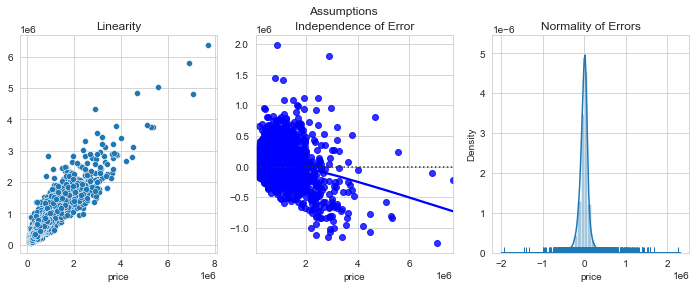

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
fig.suptitle('Assumptions')
sns.scatterplot(x=model_data2['price'], y=y_pred, ax=ax[0])
ax[0].set_title('Linearity')
sns.residplot(x=model_data2['price'], y=y_pred, lowess=True, color="b", ax=ax[1])
ax[1].set_title('Independence of Error')
residuals =  model_data2['price']- y_pred
sns.distplot(residuals, kde=True, rug=True)
ax[2].set_title('Normality of Errors');

The Normality of Errors has been resolved. And according to the Durbin Watson score, the Independence of Error assumption has been met. 

# Train/Test Split

I am now going to use train test split on the model for efficiency evaluation. Later I will use some feature selection to possibly filter out some unneccessary features to see if the model can be further improved.

In [64]:
#Accessing the features and target for the train test split
df_features = model_data2.iloc[:,1:]
target = model_data2['price']

#creating a function for train/test because I will use it later:

def train_test(df_features, target):
    X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=9,test_size=0.2)

    #instantiate a linear regression objectd
    lm = LinearRegression()

    #fit the linear regression to the data
    lm = lm.fit(X_train, y_train)

    y_train_pred = lm.predict(X_train)

    #use fitted model to predict on the test examples
    y_test_pred = lm.predict(X_test)

    #evaluate the predictions on the test examples
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

    #evaluating the train examples
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    
    return (f'Train: {train_rmse}, Test: {test_rmse}')

improved_basic = train_test(df_features, target)
print(improved_basic)

Train: 148255.18629544985, Test: 142530.6791156067


# Feature Selection

### VIF

As a method of feature selection, I am going to utilize VIF I am hoping to check to see if any of the columns are at risk of violating multicollinearity in the newer model.

In [65]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_features.values, i) for i in range(df_features.shape[1])]
vif["features"] = df_features.columns
vif.round(1)

,VIF Factor,features
0,1.6,waterfront
1,92.7,sqft_above
2,6.9,sqft_basement
3,417.0,log_yard
4,2270.3,log_neighbor
...,...,...
100,2.0,zipcode_98199
101,9.7,bedbath
102,28.6,sqft_living2
103,11.2,sqft_living152


In [66]:
vif[(vif['VIF Factor'] > 5) & (vif['VIF Factor'] < 10)]

,VIF Factor,features
2,6.945244,sqft_basement
19,5.876551,grade_12
101,9.725021,bedbath
104,6.049771,floors2


These four features have a VIF Factor in the range 5-10. This is a range I do not want to see, so I will simply eliminate them and down below I will re-evaluate a train test score to see if there is an improvement.

In [67]:
#creating a new df
df_postvif = df_features.copy()

#dropping the features that showed a bad VIF Factor above
df_postvif.drop(columns = ['sqft_basement', 'grade_12', 'bedbath', 'floors2'], inplace = True)

### Select K Best

I am also going to create a new version of the model utilizing the SelectKBest technique. Once this is done, I will compare the train test scores of the three models and choose a winner.

In [68]:
#creating an instance of SelectKBest with the top 100 features
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=9,test_size=0.2)

selector = SelectKBest(f_regression, k=100)

selector.fit(X_train, y_train)

SelectKBest(k=100, score_func=<function f_regression at 0x7f82db69d280>)

In [69]:
#These are the selected columns
selected_columns = list(X_train.columns[selector.get_support()])

#These are the removed columns
removed_columns = list(X_train.columns[~selector.get_support()])

In [70]:
selected_columns[:5]

['waterfront', 'sqft_above', 'sqft_basement', 'log_yard', 'log_neighbor']

# Bringing Back Train/Test Split for Comparisons

In [71]:
#VIF Model

#Accessing the features and target for the train test split
df_viffeatures = df_postvif.iloc[:,1:]
targetvif = model_data2['price']

vifmodel = train_test(df_viffeatures, targetvif)
print(vifmodel)

Train: 154932.49540607352, Test: 141391.46953635785


In [72]:
#SelectKBest Model

df_selectfeatures = model_data2[selected_columns]
targetselect = model_data2['price']

selectkmodel = train_test(df_selectfeatures, targetselect)
print(selectkmodel)

Train: 148437.0635094636, Test: 142713.3504578785


In [73]:
print(f'Models: \nImproved Original: {improved_basic} \n\nVIF: {vifmodel} \n\nSelectK: {selectkmodel}')

Models: 
Improved Original: Train: 148255.18629544985, Test: 142530.6791156067 

VIF: Train: 154932.49540607352, Test: 141391.46953635785 

SelectK: Train: 148437.0635094636, Test: 142713.3504578785


# Model Decision

Comparing the three models, I would have to choose the Improved Original model. This model produced the lowest Train RMSE and the Test RMSE was not higher, so no overfitting is indicated. Also, the r^2 value of this model is .84. This means 84% of the variance in price is explained by the independent variables.

# Fitting the Final Model / Pickling

In [74]:
#FITTING THE MODEL
lm_final = LinearRegression()

#fit Improved Original model to linear regression to the data
lm_final = lm_final.fit(model_data2[features2], model_data2['price'])

In [75]:
#PICKLING PROCESS
pickle_out = open("Data/model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()

Below I am adding a list of variables that I wish to use in the holdout set. I am going to also bring in a column list to compare it to the holdout set.

In [76]:
#adding a list of columns to the other_info:
column_list=list(model_data2.columns[1:]) #taking all the columns except the target variable

In [77]:
other_info = [bedroom_mean, bathroom_median, sqft_living_median, sqft_above_median, yard_size_mean, column_list]

In [78]:
pickle_out = open('Data/other_info.pickle', "wb")
pickle.dump(other_info, pickle_out)
pickle_out.close()